In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
detection_imgs = np.load('./detection/detection_imgs.npy')
detection_labs = np.load('./detection/detection_labs.npy')
detection_width = np.load('./detection/detection_width.npy')
detection_imgs = detection_imgs.astype(np.float32)
detection_labs = detection_labs.astype(np.float32)
detection_width = detection_width.astype(np.float32)
print(detection_imgs.shape)
print(detection_labs.shape)
print(detection_width.shape)
detection_imgs = detection_imgs.reshape(-1,1,16,16)
detection_labs = detection_labs.reshape(-1,1)
detection_width = detection_width.reshape(-1,1)
x_torch = Variable(torch.from_numpy(detection_imgs))
y_torch = Variable(torch.from_numpy(detection_labs))
z_torch = Variable(torch.from_numpy(detection_width))
print(x_torch.shape)
print(y_torch.shape)
print(z_torch.shape)
# print(x_torch.shape[0])

(64, 16, 16)
(64,)
(64,)
torch.Size([64, 1, 16, 16])
torch.Size([64, 1])
torch.Size([64, 1])


In [4]:
class Model_label(torch.nn.Module):
    def __init__(self):
        super(Model_label,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,16,kernel_size = 7)
        self.conv2 = torch.nn.Conv2d(16,8,kernel_size = 7)
        self.fc = torch.nn.Linear(8*16,1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self,x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(in_size,-1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class Model_width(torch.nn.Module):
    def __init__(self):
        super(Model_width,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,16,kernel_size = 7)
        self.conv2 = torch.nn.Conv2d(16,8,kernel_size = 7)
        self.fc = torch.nn.Linear(8*16,1)
    def forward(self,x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(in_size,-1)
        x = self.fc(x)
        return x
    
model_label = Model_label()
model_width = Model_width()

for m in model_label.modules():
    if isinstance(m,torch.nn.Linear):
        torch.nn.init.normal(m.weight,mean=0,std=0.1)
        torch.nn.init.constant(m.bias,0.1)

for m in model_width.modules():
    if isinstance(m,torch.nn.Linear):
        torch.nn.init.normal(m.weight,mean=0,std=0.1)
        torch.nn.init.constant(m.bias,0.1)
        
label_criterion = torch.nn.BCELoss(size_average = True)
label_optimizer = torch.optim.SGD(model_label.parameters(),lr=0.1) 

width_criterion = torch.nn.MSELoss(size_average = True)
width_optimizer = torch.optim.SGD(model_width.parameters(),lr=0.001) 

label_loss_array = []
width_loss_array = []
label_accuracy_array = []
width_accuracy_array = []

for epoch in range(3500):
    label_outputs = model_label(x_torch)
    label_loss = label_criterion(label_outputs, y_torch)
    
    width_outputs = model_width(x_torch)
    width_loss = width_criterion(width_outputs, z_torch)

    label_pred = label_outputs.clone()
    label_pred[label_pred>=0.5] = 1
    label_pred[label_pred<0.5] = 0
    label_acc = torch.sum(torch.isclose(label_pred,y_torch)).item()/y_torch.shape[0]
    
    width_pred = width_outputs.clone()
    width_acc = 0
    for i in range(width_pred.shape[0]):
        if width_pred[i] >= z_torch[i]-0.5 and width_pred[i] <= z_torch[i]+0.5:
            width_acc += 1

#     width_pred[width_pred>=0.5] = 1
#     width_pred[width_pred<0.5] = 0
#     label_acc = torch.sum(torch.isclose(label_pred,y_torch)).item()/y_torch.shape[0]
    
    if epoch % 50 == 0:
        print(epoch,label_loss.item())
        print(epoch,label_acc)
        print(epoch,width_loss.item())
        print(epoch,width_acc/64)
        
    label_loss_array.append(label_loss)
    label_accuracy_array.append(label_acc)
    width_loss_array.append(width_loss)
    width_accuracy_array.append(width_acc/64)
    
    label_optimizer.zero_grad()
    label_loss.backward()
    label_optimizer.step()
    
    width_optimizer.zero_grad()
    width_loss.backward()
    width_optimizer.step()    

/Users/cacikkong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/Users/cacikkong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/Users/cacikkong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/Users/cacikkong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/Users/cacikkong/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 0.6910749077796936
0 0.515625
0 12.77225112915039
0 0.0
50 0.4174756705760956
50 0.84375
50 0.5512977838516235
50 0.40625
100 0.24330450594425201
100 0.953125
100 0.43946927785873413
100 0.515625
150 0.06261744350194931
150 1.0
150 0.3733651340007782
150 0.578125
200 0.028786851093173027
200 1.0
200 0.33257555961608887
200 0.578125
250 0.016206886619329453
250 1.0
250 0.3071499168872833
250 0.625
300 0.010507866740226746
300 1.0
300 0.2893317639827728
300 0.640625
350 0.007453254424035549
350 1.0
350 0.2756158113479614
350 0.625
400 0.005613729823380709
400 1.0
400 0.2639300227165222
400 0.625
450 0.004423107486218214
450 1.0
450 0.2536100447177887
450 0.625
500 0.0036048199981451035
500 1.0
500 0.24411249160766602
500 0.609375
550 0.003015517257153988
550 1.0
550 0.23522219061851501
550 0.640625
600 0.0025736649986356497
600 1.0
600 0.2267506718635559
600 0.640625
650 0.00223184609785676
650 1.0
650 0.2186446189880371
650 0.65625
700 0.0019617248326539993
700 1.0
700 0.2107933163642

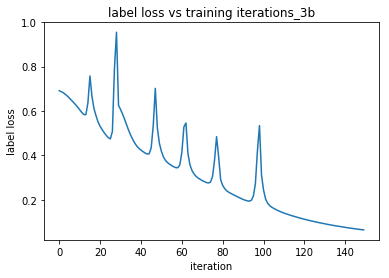

In [6]:
x = np.arange(0,150,1)
y = label_loss_array[:150]
fig = plt.figure()
plt.plot(x,y)
plt.title('label loss vs training iterations_3b')
plt.xlabel('iteration')
plt.ylabel('label loss')
plt.savefig('3b_label loss')

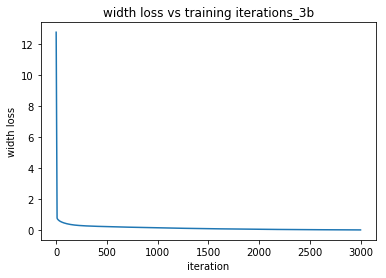

In [8]:
x = np.arange(0,3000,1)
y = width_loss_array[:3000]
fig = plt.figure()
plt.plot(x,y)
plt.title('width loss vs training iterations_3b')
plt.xlabel('iteration')
plt.ylabel('width loss')
plt.savefig('3b_width loss')

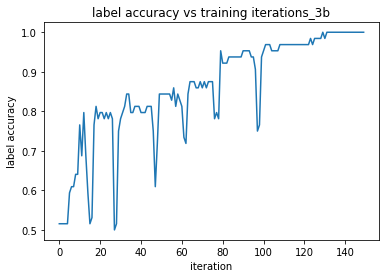

In [9]:
x = np.arange(0,150,1)
y = label_accuracy_array[:150]
fig = plt.figure()
plt.plot(x,y)
plt.title('label accuracy vs training iterations_3b')
plt.xlabel('iteration')
plt.ylabel('label accuracy')
plt.savefig('3b_label accuracy')

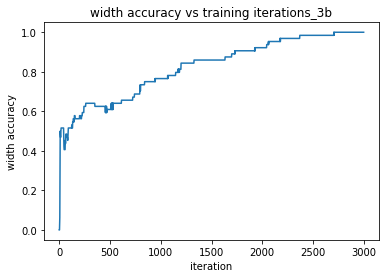

In [10]:
x = np.arange(0,3000,1)
y = width_accuracy_array[:3000]
fig = plt.figure()
plt.plot(x,y)
plt.title('width accuracy vs training iterations_3b')
plt.xlabel('iteration')
plt.ylabel('width accuracy')
plt.savefig('3b_width accuracy')